# Fake News Detection 

# Libraries Imported

In [10]:
import numpy as np 
import pandas as pd 
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# Reading Data

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
true_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [13]:
fake_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [14]:
fake_data['label'] = 1
true_data['label'] = 0 
data = pd.concat([true_data,fake_data],axis=0,ignore_index=True)
display(data.head())
display(data.tail())

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


,title,text,subject,date,label
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


# Data Preprossing

In [15]:
x= data.copy()
df= x.sample(frac=1)
y = df[['label']]
df_x= df.drop('label',axis = 1)

df_x.isnull().sum() 

title      0
text       0
subject    0
date       0
dtype: int64

In [16]:
import nltk
nltk.download('stopwords')
def cleantext(text):
    stemmer = PorterStemmer()
    text = str(text)
    cleantext = re.sub('[^a-zA-Z]', ' ', text)
    cleantext = cleantext.lower()
    cleantext = cleantext.split()
    cleantext = [stemmer.stem(word) for word in cleantext if not word in set(stopwords.words('english'))]
    cleantext = ' '.join(cleantext) 
    return cleantext
df_x['cleantext']= df_x['text'].apply(cleantext)
df_x.to_csv('clean_data.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
y = df[['label']]

# Data Splitting

In [18]:
from sklearn.model_selection import train_test_split

df_x['cleantext'] = df_x['cleantext'].astype(str)
X = df_x['cleantext'].values
y1 =y.values
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=0.3, random_state=42, shuffle = True)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# Feature Extraction 

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer(num_words = 10000)

tokenizer_obj.fit_on_texts(x_train)

max_length = 120

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(x_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(x_test)
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

# Model Buildings

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_dim = 300

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(LSTM(75))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

# model.summary()

In [21]:
# train model
model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))

Epoch 1/5
983/983 [==============================] - 376s 380ms/step - loss: 0.3421 - accuracy: 0.8459 - val_loss: 0.2238 - val_accuracy: 0.8852
Epoch 2/5
983/983 [==============================] - 377s 384ms/step - loss: 0.1672 - accuracy: 0.9294 - val_loss: 0.0685 - val_accuracy: 0.9783
Epoch 3/5
983/983 [==============================] - 377s 383ms/step - loss: 0.0417 - accuracy: 0.9870 - val_loss: 0.0496 - val_accuracy: 0.9845
Epoch 4/5
983/983 [==============================] - 374s 381ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0549 - val_accuracy: 0.9847
Epoch 5/5
983/983 [==============================] - 377s 383ms/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 0.0696 - val_accuracy: 0.9845


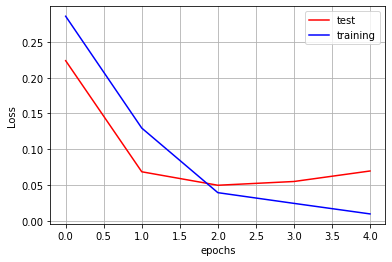

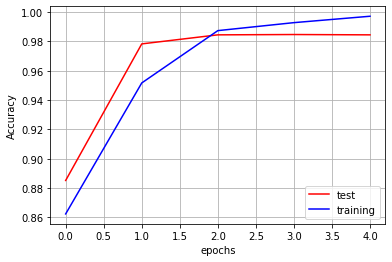

In [22]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(model):
    epochs = model.history.params['epochs']
    epochs = range(epochs)
    val_loss = model.history.history['val_loss']
    val_accuracy = model.history.history['val_accuracy']
    training_loss = model.history.history['loss']
    training_accuracy = model.history.history['accuracy']

    plt.plot(epochs, val_loss, 'r', label='test')
    plt.plot(epochs, training_loss, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.plot(epochs, val_accuracy, 'r', label='test')
    plt.plot(epochs, training_accuracy, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy_and_loss(model)

In [23]:
import pickle
# pickle.dump(
# model,"model2k")
model.save('model.h5')

# Testing on COVID19 Fake News

In [ ]:
from google.colab import files
uploaded = files.upload()

In [30]:
F = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Fake_covid19.csv', encoding= 'unicode_escape')
F['label'] = 1
# F.head()
T= pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/True_covid19.csv')
T['label'] = 0 
# T.head()
testing_dataset= pd.concat([F, T],axis=0,ignore_index=True)
testing_dataset['label'].value_counts()

1    23311
0      474
Name: label, dtype: int64

In [35]:
covid_test = testing_dataset.sample(frac=1)
covid_x = covid_test[['headlines']]
covid_y = covid_test[['label']]
covid_test['cleaned_x']= covid_x['headlines'].apply(cleantext)

In [36]:
testing_dataset.isnull().sum()
covid_test[['headlines']].astype(str).dtypes

headlines    object
dtype: object

In [37]:
X_test_covid_tokens = tokenizer_obj.texts_to_sequences(covid_test['cleaned_x'])

testing_dataset.isnull().sum()
covid_test[['headlines']].astype(str).dtypes

X_test_covid_pad = pad_sequences(X_test_covid_tokens, maxlen=max_length, padding='post')

ypredicted = model.predict(X_test_covid_pad, verbose = 0)

In [38]:
scores = model.evaluate(X_test_covid_pad, covid_y['label'].to_numpy(), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.99%
